In [4]:
import os
from pathlib import Path
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from skimage import exposure
from skimage.filters import frangi
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------------------ Device Configuration ------------------------

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ------------------------ Dataset Definition ------------------------

class VesselDataset(Dataset):
    """
    PyTorch Dataset for vessel segmentation with Frangi + CLAHE preprocessing and patch extraction.
    """
    def __init__(
        self,
        images_dir: Path,
        masks_dir: Path,
        patch_size: int = 64,
        stride: int = 64,
    ):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.patch_size = patch_size
        self.stride = stride
        self.image_paths = sorted(images_dir.glob("*.tif"))
        self.mask_paths = sorted(masks_dir.glob("*.gif"))
        assert len(self.image_paths) == len(self.mask_paths), \
            "Number of images and masks must match"
        self.patches = []
        self._prepare_patches()

    def _enhance(self, img: np.ndarray) -> np.ndarray:
        # Normalize grayscale
        img = (img - img.min()) / (img.max() - img.min())
        # CLAHE
        img = exposure.equalize_adapthist(img)
        # Frangi vesselness
        img = frangi(img)
        # Renormalize to [0,1]
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        return img.astype(np.float32)

    def _prepare_patches(self):
        for img_path, mask_path in zip(self.image_paths, self.mask_paths):
            img = np.array(Image.open(img_path).convert('L'), dtype=np.float32)
            mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32) / 255.0
            img = self._enhance(img)
            mask = (mask > 0.5).astype(np.float32)
            h, w = img.shape
            for y in range(0, h - self.patch_size + 1, self.stride):
                for x in range(0, w - self.patch_size + 1, self.stride):
                    img_patch = img[y:y + self.patch_size, x:x + self.patch_size]
                    mask_patch = mask[y:y + self.patch_size, x:x + self.patch_size]
                    self.patches.append((img_patch, mask_patch))

    def __len__(self) -> int:
        return len(self.patches)

    def __getitem__(self, idx: int):
        img, mask = self.patches[idx]
        # Add channel dim
        img = torch.from_numpy(img).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0)
        return img.to(DEVICE), mask.to(DEVICE)

# ------------------------ Model Definition ------------------------

def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.SiLU(),
    )

class GeGLU(nn.Module):
    def __init__(self, in_dim, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_dim * 2
        self.proj = nn.Linear(in_dim, hidden_dim)
        self.gate = nn.Linear(in_dim, hidden_dim)

    def forward(self, x):
        x_flat = x.flatten(2).transpose(1, 2)
        proj = self.proj(x_flat)
        gate = torch.sigmoid(self.gate(x_flat))
        out = proj * gate
        out = out.transpose(1, 2).view_as(x)
        return out

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, bias=False),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, bias=False),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = torch.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class GeGLUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.attn_gates = nn.ModuleList()
        # Encoder
        prev_ch = in_ch
        for feat in features:
            self.encoder.append(conv_block(prev_ch, feat))
            prev_ch = feat
        # Bottleneck
        self.bottleneck = conv_block(features[-1], features[-1] * 2)
        # Decoder
        for feat in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feat * 2, feat, kernel_size=2, stride=2))
            self.decoder.append(conv_block(feat * 2, feat))
            self.attn_gates.append(AttentionGate(F_g=feat, F_l=feat, F_int=feat // 2))
        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_ch, kernel_size=1)

    def forward(self, x):
        enc_feats = []
        for layer in self.encoder:
            x = layer(x)
            enc_feats.append(x)
            x = nn.MaxPool2d(2)(x)
        x = self.bottleneck(x)
        # Decoder
        for idx in range(0, len(self.decoder), 2):
            up = self.decoder[idx](x)
            skip = enc_feats[-(idx//2 + 1)]
            gated = self.attn_gates[idx//2](g=up, x=skip)
            x = torch.cat([up, gated], dim=1)
            x = self.decoder[idx+1](x)
        return torch.sigmoid(self.final_conv(x))

# ------------------------ Loss & Metrics ------------------------

class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def dice_loss(self, preds, targets, eps=1e-6):
        num = 2 * (preds * targets).sum(dim=(1,2,3))
        den = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
        return 1 - ((num + eps) / (den + eps)).mean()

    def jaccard_loss(self, preds, targets, eps=1e-6):
        inter = (preds * targets).sum(dim=(1,2,3))
        union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - inter
        return 1 - ((inter + eps) / (union + eps)).mean()

    def sobel_loss(self, preds, targets):
        Gx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32, device=preds.device).unsqueeze(0).unsqueeze(0)
        Gy = Gx.transpose(2,3)
        pred_grad_x = nn.functional.conv2d(preds, Gx, padding=1)
        pred_grad_y = nn.functional.conv2d(preds, Gy, padding=1)
        targ_grad_x = nn.functional.conv2d(targets, Gx, padding=1)
        targ_grad_y = nn.functional.conv2d(targets, Gy, padding=1)
        return nn.functional.l1_loss(pred_grad_x + pred_grad_y, targ_grad_x + targ_grad_y)

    def forward(self, preds, targets):
        bce_loss = self.bce(preds, targets)
        d_loss = self.dice_loss(preds, targets)
        j_loss = self.jaccard_loss(preds, targets)
        s_loss = self.sobel_loss(preds, targets)
        # LPCL contrastive on bottleneck features can be added here
        return bce_loss + d_loss + j_loss + s_loss

# ------------------------ Training & Evaluation ------------------------

def train(model, loader, criterion, optimizer, epoch):
    model.train()
    loop = tqdm(loader, desc=f"Epoch {epoch+1}")
    total_loss = 0.0
    all_preds = []
    all_masks = []
    for imgs, masks in loop:
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
        all_preds.append(preds.detach().cpu())
        all_masks.append(masks.detach().cpu())
    avg_loss = total_loss / len(loader)
    # Metrics calculation (over all batches)
    preds_cat = torch.cat(all_preds)  # [N,1,H,W]
    masks_cat = torch.cat(all_masks)
    preds_bin = (preds_cat > 0.5).float()
    # Dice/F1
    tp = (preds_bin * masks_cat).sum()
    fp = (preds_bin * (1 - masks_cat)).sum()
    fn = ((1 - preds_bin) * masks_cat).sum()
    tn = ((1 - preds_bin) * (1 - masks_cat)).sum()
    dice = (2 * tp) / (2 * tp + fp + fn + 1e-6)
    se = tp / (tp + fn + 1e-6)
    sp = tn / (tn + fp + 1e-6)
    miou = tp / (tp + fp + fn + 1e-6)
    # AUC: placeholder (requires probs and sklearn)
    auc = 0.0
    # HD95: placeholder (requires external library)
    hd95 = 0.0
    metrics = {
        'loss': avg_loss,
        'dice': dice.item(),
        'se': se.item(),
        'sp': sp.item(),
        'hd95': hd95,
        'auc': auc,
        'miou': miou.item()
    }
    return metrics

# ------------------------ Inference with TTA ------------------------

def inference_tta(model, img: torch.Tensor) -> torch.Tensor:
    """
    Perform inference with test-time augmentation on a 4D batched image tensor.

    Args:
        model: The segmentation model.
        img: torch.Tensor of shape [B=1, C, H, W].
    Returns:
        torch.Tensor of shape [C, H, W].
    """
    model.eval()
    augs = [
        lambda x: x,
        lambda x: torch.flip(x, dims=[-1]),
        lambda x: torch.flip(x, dims=[-2]),
        lambda x: torch.rot90(x, k=1, dims=[-2, -1]),
        lambda x: torch.rot90(x, k=-1, dims=[-2, -1]),
    ]
    preds = []
    with torch.no_grad():
        for aug in augs:
            aug_img = aug(img)
            out = model(aug_img)
            out = aug(out)
            preds.append(out)
    preds = torch.stack(preds)
    mean_pred = preds.mean(dim=0)
    return mean_pred.squeeze(0)

# ------------------------ Visualization ------------------------

def visualize_results(
    orig: np.ndarray,
    mask: np.ndarray,
    pred: np.ndarray,
    save_path: Path = None
):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(orig, cmap='gray')
    axes[0].set_title('Original')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Ground Truth')
    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title('Prediction')
    for ax in axes:
        ax.axis('off')
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ------------------------ Main Execution ------------------------

if __name__ == '__main__':
    # Configuration
    data_root = Path('/Users/imamahasan/MyData/Code/Retinal_Vessel_S')
    train_images = data_root / 'training/images'
    train_masks = data_root / 'training/1st_manual'
    # test_image_path = data_root / 'test/images/test.tif'

    # DataLoader
    dataset = VesselDataset(train_images, train_masks)
    loader = DataLoader(dataset, batch_size=25, shuffle=True)

    # Model, Loss, Optimizer
    model = GeGLUNet().to(DEVICE)
    criterion = HybridLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    # Training Loop with metrics printing
    for epoch in range(50):
        metrics = train(model, loader, criterion, optimizer, epoch)
        print(f"\nEpoch {epoch+1:03d} Results:")
        print(f"Loss: {metrics['loss']:.4f}")
        print(f"Dice/F1: {metrics['dice']:.4f}")
        print(f"Sensitivity (SE): {metrics['se']:.4f}")
        print(f"Specificity (SP): {metrics['sp']:.4f}")
        print(f"HD95: {metrics['hd95']:.4f} px")
        print(f"AUC: {metrics['auc']:.4f}")
        print(f"MIoU: {metrics['miou']:.4f}")

    # Save model
    torch.save(model.state_dict(), 'geglu_unet_vessel.pth')

Using device: mps


Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 16.49it/s, loss=1.75]



Epoch 001 Results:
Loss: 2.3218
Dice/F1: 0.6153
Sensitivity (SE): 0.7085
Specificity (SP): 0.9386
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.4443


Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 18.30it/s, loss=1.85]



Epoch 002 Results:
Loss: 1.8187
Dice/F1: 0.6704
Sensitivity (SE): 0.6359
Specificity (SP): 0.9730
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.5042


Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 18.29it/s, loss=1.47]



Epoch 003 Results:
Loss: 1.6501
Dice/F1: 0.7143
Sensitivity (SE): 0.6857
Specificity (SP): 0.9758
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.5556


Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 18.21it/s, loss=1.41]



Epoch 004 Results:
Loss: 1.5869
Dice/F1: 0.7305
Sensitivity (SE): 0.6982
Specificity (SP): 0.9780
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.5755


Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 18.29it/s, loss=1.4] 



Epoch 005 Results:
Loss: 1.5563
Dice/F1: 0.7379
Sensitivity (SE): 0.7130
Specificity (SP): 0.9773
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.5846


Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 18.30it/s, loss=1.59]



Epoch 006 Results:
Loss: 1.5380
Dice/F1: 0.7437
Sensitivity (SE): 0.7206
Specificity (SP): 0.9776
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.5919


Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 18.40it/s, loss=1.42]



Epoch 007 Results:
Loss: 1.5061
Dice/F1: 0.7513
Sensitivity (SE): 0.7244
Specificity (SP): 0.9789
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6016


Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 18.32it/s, loss=1.46]



Epoch 008 Results:
Loss: 1.4903
Dice/F1: 0.7559
Sensitivity (SE): 0.7324
Specificity (SP): 0.9788
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6076


Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 18.28it/s, loss=1.52]



Epoch 009 Results:
Loss: 1.4865
Dice/F1: 0.7571
Sensitivity (SE): 0.7319
Specificity (SP): 0.9792
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6091


Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 18.35it/s, loss=1.51]



Epoch 010 Results:
Loss: 1.4858
Dice/F1: 0.7566
Sensitivity (SE): 0.7328
Specificity (SP): 0.9789
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6085


Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 18.24it/s, loss=1.59]



Epoch 011 Results:
Loss: 1.4561
Dice/F1: 0.7657
Sensitivity (SE): 0.7434
Specificity (SP): 0.9795
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6204


Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 18.00it/s, loss=1.68]



Epoch 012 Results:
Loss: 1.4538
Dice/F1: 0.7648
Sensitivity (SE): 0.7361
Specificity (SP): 0.9805
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6192


Epoch 13: 100%|██████████| 58/58 [00:03<00:00, 18.25it/s, loss=1.43]



Epoch 013 Results:
Loss: 1.4300
Dice/F1: 0.7715
Sensitivity (SE): 0.7497
Specificity (SP): 0.9800
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6280


Epoch 14: 100%|██████████| 58/58 [00:03<00:00, 18.34it/s, loss=1.45]



Epoch 014 Results:
Loss: 1.4188
Dice/F1: 0.7747
Sensitivity (SE): 0.7519
Specificity (SP): 0.9805
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6322


Epoch 15: 100%|██████████| 58/58 [00:03<00:00, 18.27it/s, loss=1.5] 



Epoch 015 Results:
Loss: 1.4154
Dice/F1: 0.7761
Sensitivity (SE): 0.7519
Specificity (SP): 0.9808
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6341


Epoch 16: 100%|██████████| 58/58 [00:03<00:00, 18.39it/s, loss=1.33]



Epoch 016 Results:
Loss: 1.3984
Dice/F1: 0.7802
Sensitivity (SE): 0.7546
Specificity (SP): 0.9814
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6396


Epoch 17: 100%|██████████| 58/58 [00:03<00:00, 18.27it/s, loss=1.49]



Epoch 017 Results:
Loss: 1.3929
Dice/F1: 0.7818
Sensitivity (SE): 0.7617
Specificity (SP): 0.9807
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6418


Epoch 18: 100%|██████████| 58/58 [00:03<00:00, 18.15it/s, loss=1.32]



Epoch 018 Results:
Loss: 1.3874
Dice/F1: 0.7823
Sensitivity (SE): 0.7563
Specificity (SP): 0.9817
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6424


Epoch 19: 100%|██████████| 58/58 [00:03<00:00, 18.23it/s, loss=1.26]



Epoch 019 Results:
Loss: 1.3691
Dice/F1: 0.7875
Sensitivity (SE): 0.7658
Specificity (SP): 0.9815
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6495


Epoch 20: 100%|██████████| 58/58 [00:03<00:00, 18.17it/s, loss=1.48]



Epoch 020 Results:
Loss: 1.3554
Dice/F1: 0.7913
Sensitivity (SE): 0.7708
Specificity (SP): 0.9817
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6546


Epoch 21: 100%|██████████| 58/58 [00:03<00:00, 18.38it/s, loss=1.18]



Epoch 021 Results:
Loss: 1.3542
Dice/F1: 0.7911
Sensitivity (SE): 0.7691
Specificity (SP): 0.9819
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6543


Epoch 22: 100%|██████████| 58/58 [00:03<00:00, 18.33it/s, loss=1.26]



Epoch 022 Results:
Loss: 1.3397
Dice/F1: 0.7953
Sensitivity (SE): 0.7750
Specificity (SP): 0.9820
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6602


Epoch 23: 100%|██████████| 58/58 [00:03<00:00, 18.35it/s, loss=1.37]



Epoch 023 Results:
Loss: 1.3344
Dice/F1: 0.7957
Sensitivity (SE): 0.7756
Specificity (SP): 0.9820
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6607


Epoch 24: 100%|██████████| 58/58 [00:03<00:00, 18.34it/s, loss=1.41]



Epoch 024 Results:
Loss: 1.3250
Dice/F1: 0.7978
Sensitivity (SE): 0.7760
Specificity (SP): 0.9825
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6637


Epoch 25: 100%|██████████| 58/58 [00:03<00:00, 18.34it/s, loss=1.27]



Epoch 025 Results:
Loss: 1.3078
Dice/F1: 0.8030
Sensitivity (SE): 0.7833
Specificity (SP): 0.9827
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6708


Epoch 26: 100%|██████████| 58/58 [00:03<00:00, 18.37it/s, loss=1.31]



Epoch 026 Results:
Loss: 1.3038
Dice/F1: 0.8045
Sensitivity (SE): 0.7846
Specificity (SP): 0.9829
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6730


Epoch 27: 100%|██████████| 58/58 [00:03<00:00, 18.32it/s, loss=1.37]



Epoch 027 Results:
Loss: 1.2835
Dice/F1: 0.8085
Sensitivity (SE): 0.7901
Specificity (SP): 0.9830
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6785


Epoch 28: 100%|██████████| 58/58 [00:03<00:00, 18.41it/s, loss=1.23]



Epoch 028 Results:
Loss: 1.2789
Dice/F1: 0.8092
Sensitivity (SE): 0.7894
Specificity (SP): 0.9833
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6796


Epoch 29: 100%|██████████| 58/58 [00:03<00:00, 18.31it/s, loss=1.48]



Epoch 029 Results:
Loss: 1.2614
Dice/F1: 0.8148
Sensitivity (SE): 0.7988
Specificity (SP): 0.9833
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6875


Epoch 30: 100%|██████████| 58/58 [00:03<00:00, 18.28it/s, loss=1.49]



Epoch 030 Results:
Loss: 1.2547
Dice/F1: 0.8163
Sensitivity (SE): 0.7974
Specificity (SP): 0.9839
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6896


Epoch 31: 100%|██████████| 58/58 [00:03<00:00, 18.38it/s, loss=1.33]



Epoch 031 Results:
Loss: 1.2413
Dice/F1: 0.8194
Sensitivity (SE): 0.8043
Specificity (SP): 0.9836
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6941


Epoch 32: 100%|██████████| 58/58 [00:03<00:00, 18.37it/s, loss=1.12]



Epoch 032 Results:
Loss: 1.2333
Dice/F1: 0.8206
Sensitivity (SE): 0.8017
Specificity (SP): 0.9843
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6958


Epoch 33: 100%|██████████| 58/58 [00:03<00:00, 18.34it/s, loss=1.31]



Epoch 033 Results:
Loss: 1.2294
Dice/F1: 0.8227
Sensitivity (SE): 0.8056
Specificity (SP): 0.9842
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.6988


Epoch 34: 100%|██████████| 58/58 [00:03<00:00, 18.36it/s, loss=1.02]



Epoch 034 Results:
Loss: 1.2015
Dice/F1: 0.8274
Sensitivity (SE): 0.8116
Specificity (SP): 0.9845
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7056


Epoch 35: 100%|██████████| 58/58 [00:03<00:00, 18.32it/s, loss=1.06]



Epoch 035 Results:
Loss: 1.1916
Dice/F1: 0.8299
Sensitivity (SE): 0.8144
Specificity (SP): 0.9847
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7092


Epoch 36: 100%|██████████| 58/58 [00:03<00:00, 18.36it/s, loss=1.01]



Epoch 036 Results:
Loss: 1.1835
Dice/F1: 0.8318
Sensitivity (SE): 0.8174
Specificity (SP): 0.9847
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7120


Epoch 37: 100%|██████████| 58/58 [00:03<00:00, 18.32it/s, loss=1.17]



Epoch 037 Results:
Loss: 1.1677
Dice/F1: 0.8348
Sensitivity (SE): 0.8215
Specificity (SP): 0.9849
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7164


Epoch 38: 100%|██████████| 58/58 [00:03<00:00, 18.34it/s, loss=1.37] 



Epoch 038 Results:
Loss: 1.1461
Dice/F1: 0.8399
Sensitivity (SE): 0.8259
Specificity (SP): 0.9855
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7240


Epoch 39: 100%|██████████| 58/58 [00:03<00:00, 18.31it/s, loss=1.2]  



Epoch 039 Results:
Loss: 1.1283
Dice/F1: 0.8434
Sensitivity (SE): 0.8303
Specificity (SP): 0.9857
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7291


Epoch 40: 100%|██████████| 58/58 [00:03<00:00, 18.38it/s, loss=1.11] 



Epoch 040 Results:
Loss: 1.1271
Dice/F1: 0.8431
Sensitivity (SE): 0.8310
Specificity (SP): 0.9855
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7288


Epoch 41: 100%|██████████| 58/58 [00:03<00:00, 18.31it/s, loss=1.02] 



Epoch 041 Results:
Loss: 1.1239
Dice/F1: 0.8458
Sensitivity (SE): 0.8329
Specificity (SP): 0.9859
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7328


Epoch 42: 100%|██████████| 58/58 [00:03<00:00, 18.29it/s, loss=0.978]



Epoch 042 Results:
Loss: 1.1010
Dice/F1: 0.8497
Sensitivity (SE): 0.8375
Specificity (SP): 0.9862
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7386


Epoch 43: 100%|██████████| 58/58 [00:03<00:00, 18.30it/s, loss=1.11] 



Epoch 043 Results:
Loss: 1.0897
Dice/F1: 0.8520
Sensitivity (SE): 0.8415
Specificity (SP): 0.9862
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7422


Epoch 44: 100%|██████████| 58/58 [00:03<00:00, 18.32it/s, loss=1.17] 



Epoch 044 Results:
Loss: 1.0744
Dice/F1: 0.8547
Sensitivity (SE): 0.8433
Specificity (SP): 0.9866
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7463


Epoch 45: 100%|██████████| 58/58 [00:03<00:00, 18.28it/s, loss=1.21] 



Epoch 045 Results:
Loss: 1.0628
Dice/F1: 0.8572
Sensitivity (SE): 0.8456
Specificity (SP): 0.9868
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7500


Epoch 46: 100%|██████████| 58/58 [00:03<00:00, 18.35it/s, loss=1.22] 



Epoch 046 Results:
Loss: 1.0334
Dice/F1: 0.8621
Sensitivity (SE): 0.8516
Specificity (SP): 0.9872
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7577


Epoch 47: 100%|██████████| 58/58 [00:03<00:00, 18.26it/s, loss=1.09] 



Epoch 047 Results:
Loss: 0.9773
Dice/F1: 0.8478
Sensitivity (SE): 0.8313
Specificity (SP): 0.9866
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7358


Epoch 48: 100%|██████████| 58/58 [00:03<00:00, 18.32it/s, loss=0.715]



Epoch 048 Results:
Loss: 0.9465
Dice/F1: 0.8471
Sensitivity (SE): 0.8300
Specificity (SP): 0.9866
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7347


Epoch 49: 100%|██████████| 58/58 [00:03<00:00, 18.36it/s, loss=0.815]



Epoch 049 Results:
Loss: 0.8724
Dice/F1: 0.8574
Sensitivity (SE): 0.8451
Specificity (SP): 0.9870
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7504


Epoch 50: 100%|██████████| 58/58 [00:03<00:00, 18.32it/s, loss=0.962]



Epoch 050 Results:
Loss: 0.8403
Dice/F1: 0.8640
Sensitivity (SE): 0.8519
Specificity (SP): 0.9876
HD95: 0.0000 px
AUC: 0.0000
MIoU: 0.7605


In [ ]:
def inference_tta(model, original_path, gt_path, rect=(100,100,128)):
    model.eval()
    orig = cv2.cvtColor(cv2.imread(original_path), cv2.COLOR_BGR2RGB)
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    if gt is None:
        gt = imageio.v2.imread(gt_path)
        if gt.ndim==3: gt = cv2.cvtColor(gt, cv2.COLOR_RGB2GRAY)
    gray = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY).astype(np.float32)
    enhanced = VesselDataset.enhance(gray)
    inp = torch.from_numpy(enhanced).unsqueeze(0).unsqueeze(0).to(DEVICE)
    augs = [lambda x:x, lambda x:torch.flip(x,[-1]), lambda x:torch.flip(x,[-2]),
            lambda x:torch.rot90(x,1,[-2,-1]), lambda x:torch.rot90(x,-1,[-2,-1])]
    preds=[]
    with torch.no_grad():
        for aug in augs:
            out = model(aug(inp)); out = aug(out);
            p = out.squeeze().cpu().numpy()
            p = (p*255).astype(np.uint8)
            p = cv2.resize(p,(orig.shape[1],orig.shape[0]))
            preds.append(p)
    
    # Visualization grid
    px,py,ps=rect; n=len(preds)+2
    fig,axes=plt.subplots(2,n,figsize=(4*n,8))
    titles=['Original','GT']+ [f'Pred{i+1}' for i in range(len(preds))]
    imgs=[orig,gt]+preds
    for i,img in enumerate(imgs):
        ax=axes[0,i]; ax.axis('off'); ax.set_title(titles[i])
        ax.imshow(img, cmap='gray' if i>0 else None)
        if i==0: ax.imshow(orig)
        ax.add_patch(Rectangle((px,py),ps,ps,linewidth=2,edgecolor='lime',facecolor='none'))
    # Patches
    for i,img in enumerate(imgs):
        patch = img[py:py+ps,px:px+ps]
        ax=axes[1,i]; ax.axis('off'); ax.imshow(patch, cmap='gray' if i>0 else None)
    plt.tight_layout(); plt.savefig('model_preds.png',dpi=300); plt.show()



In [ ]:
# inference
model = inference_tta(model,'/Users/imamahasan/MyData/Code/Retinal_Vessel_S/training/images/21_training.tif',
                  '/Users/imamahasan/MyData/Code/Retinal_Vessel_S/training/1st_manual/21_manual1.gif', rect=(100,100,128))


/var/folders/qk/szcdgwl97f98j7b69xpwh2200000gn/T/ipykernel_24574/1468544497.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('checkpoint.pth', map_lo

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint.pth'

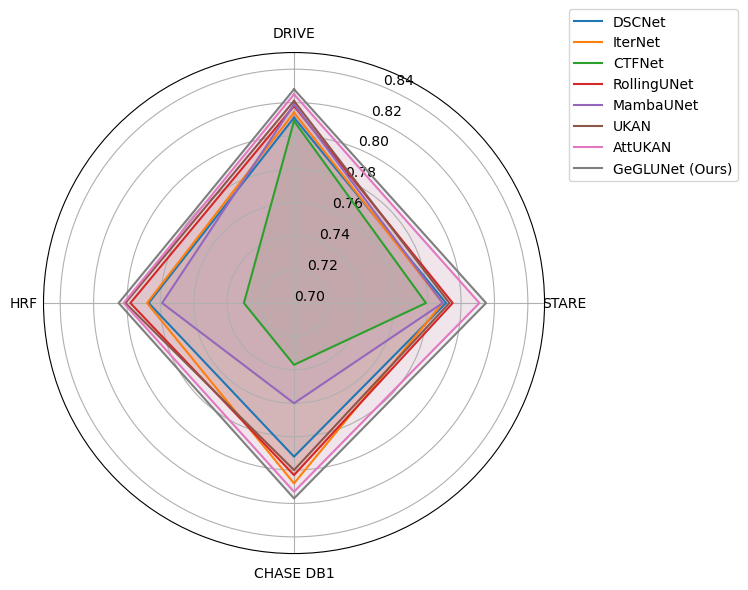

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset labels
labels = ['DRIVE', 'STARE', 'CHASE DB1', 'HRF']
num_vars = len(labels)

# Model scores
models = {
    'DSCNet': [0.811, 0.791, 0.792, 0.787],
    'IterNet': [0.814, 0.789, 0.808, 0.788],
    'CTFNet': [0.809, 0.779, 0.737, 0.730],
    'RollingUNet': [0.818, 0.795, 0.803, 0.798],
    'MambaUNet': [0.819, 0.789, 0.760, 0.779],
    'UKAN': [0.821, 0.793, 0.800, 0.801],
    'AttUKAN': [0.825, 0.811, 0.813, 0.802],
    'GeGLUNet (Ours)': [0.828, 0.815, 0.817, 0.805]
}

# Angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for name, scores in models.items():
    stats = scores + scores[:1]
    ax.plot(angles, stats, label=name)
    ax.fill(angles, stats, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0.7, 0.85)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
# plt.title("F1 Score Comparison Across Datasets", size=14)
plt.tight_layout()
plt.show()


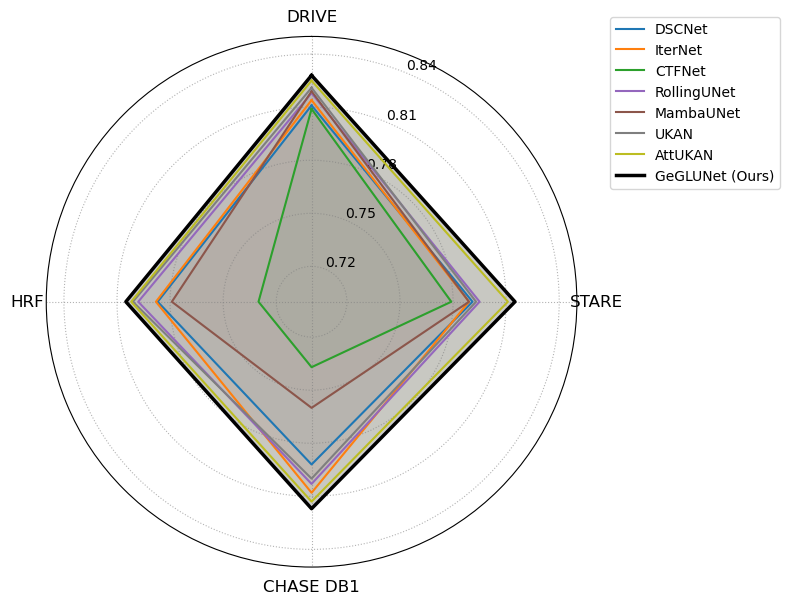

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset labels
labels = ['DRIVE', 'STARE', 'CHASE DB1', 'HRF']
num_vars = len(labels)

# Angles
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the polygon

# Scores
models = {
    'DSCNet': [0.811, 0.791, 0.792, 0.787],
    'IterNet': [0.814, 0.789, 0.808, 0.788],
    'CTFNet': [0.809, 0.779, 0.737, 0.730],
    'RollingUNet': [0.818, 0.795, 0.803, 0.798],
    'MambaUNet': [0.819, 0.789, 0.760, 0.779],
    'UKAN': [0.821, 0.793, 0.800, 0.801],
    'AttUKAN': [0.825, 0.811, 0.813, 0.802],
    'GeGLUNet (Ours)': [0.828, 0.815, 0.817, 0.805]
}

# Color mapping for consistent and elegant style
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw one line per model
for i, (model, scores) in enumerate(models.items()):
    stats = scores + scores[:1]
    if model == 'GeGLUNet (Ours)':
        ax.plot(angles, stats, color='black', linewidth=2.5, label=model, zorder=5)
        ax.fill(angles, stats, color='black', alpha=0.2)
    else:
        ax.plot(angles, stats, color=colors[i], linewidth=1.5, label=model)
        ax.fill(angles, stats, color=colors[i], alpha=0.05)

# Ticks and labels
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=12)
ax.set_ylim(0.70, 0.85)
ax.set_yticks([0.72, 0.75, 0.78, 0.81, 0.84])
ax.set_yticklabels(['0.72', '0.75', '0.78', '0.81', '0.84'], fontsize=10)
ax.grid(color='gray', linestyle='dotted', linewidth=0.8, alpha=0.6)

# Title and legend
# plt.title("F1 Score Comparison Across Datasets", fontsize=16, fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.05), fontsize=10)
plt.tight_layout()
plt.show()


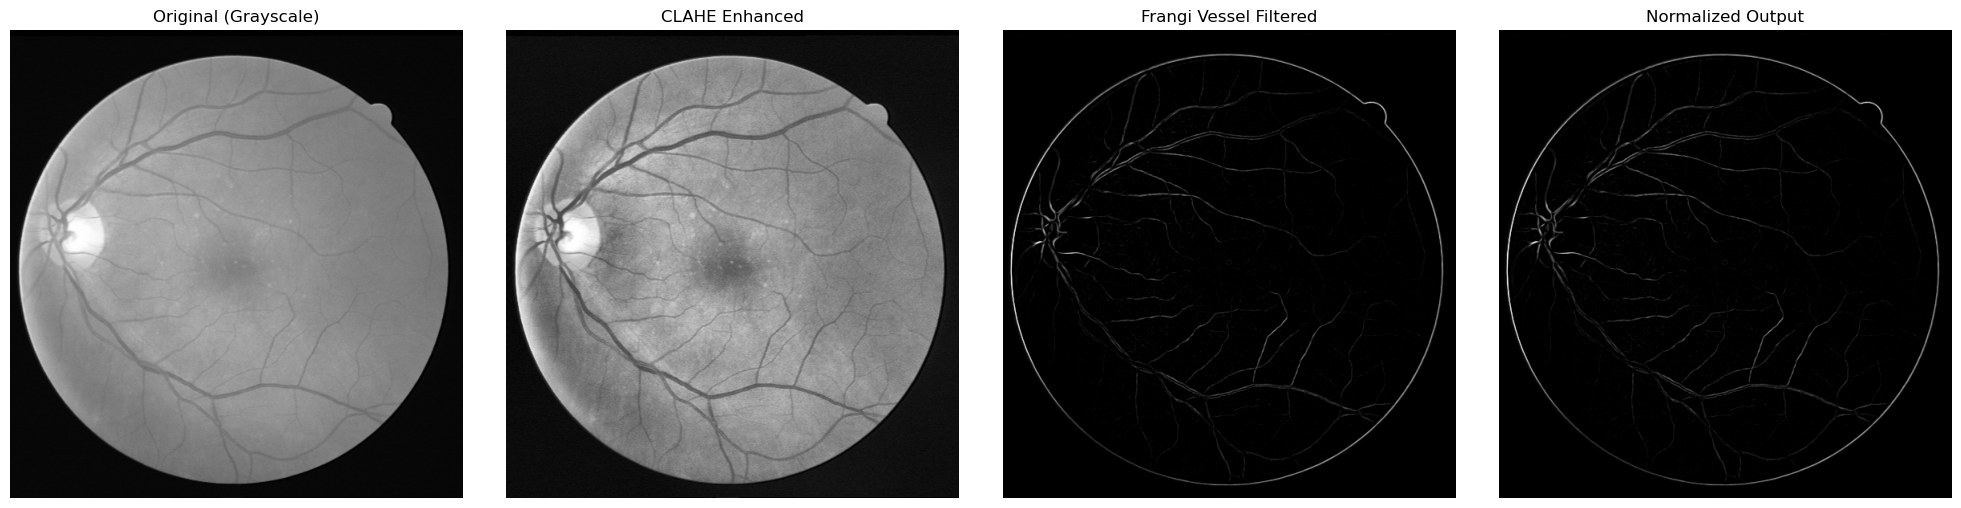

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import exposure
from skimage.filters import frangi
import os

# Load original image
image_path = '/Users/imamahasan/MyData/Code/Retinal_Vessel_S/training/images/21_training.tif'
original = Image.open(image_path).convert('L')
gray = np.array(original, dtype=np.float32)

# Step 1: Original (Grayscale)
img1 = gray.copy()

# Normalize grayscale to [0, 1]
img_norm = (img1 - img1.min()) / (img1.max() - img1.min())

# Step 2: CLAHE enhancement
img2 = exposure.equalize_adapthist(img_norm)

# Step 3: Frangi vesselness filter
img3 = frangi(img2)

# Step 4: Normalize Frangi output to [0, 1]
img4 = (img3 - img3.min()) / (img3.max() - img3.min() + 1e-8)

# Plotting
titles = ['Original (Grayscale)', 'CLAHE Enhanced', 'Frangi Vessel Filtered', 'Normalized Output']
images = [img1, img2, img3, img4]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.savefig('preprocessing_pipeline.png', dpi=300, bbox_inches='tight')
plt.show()


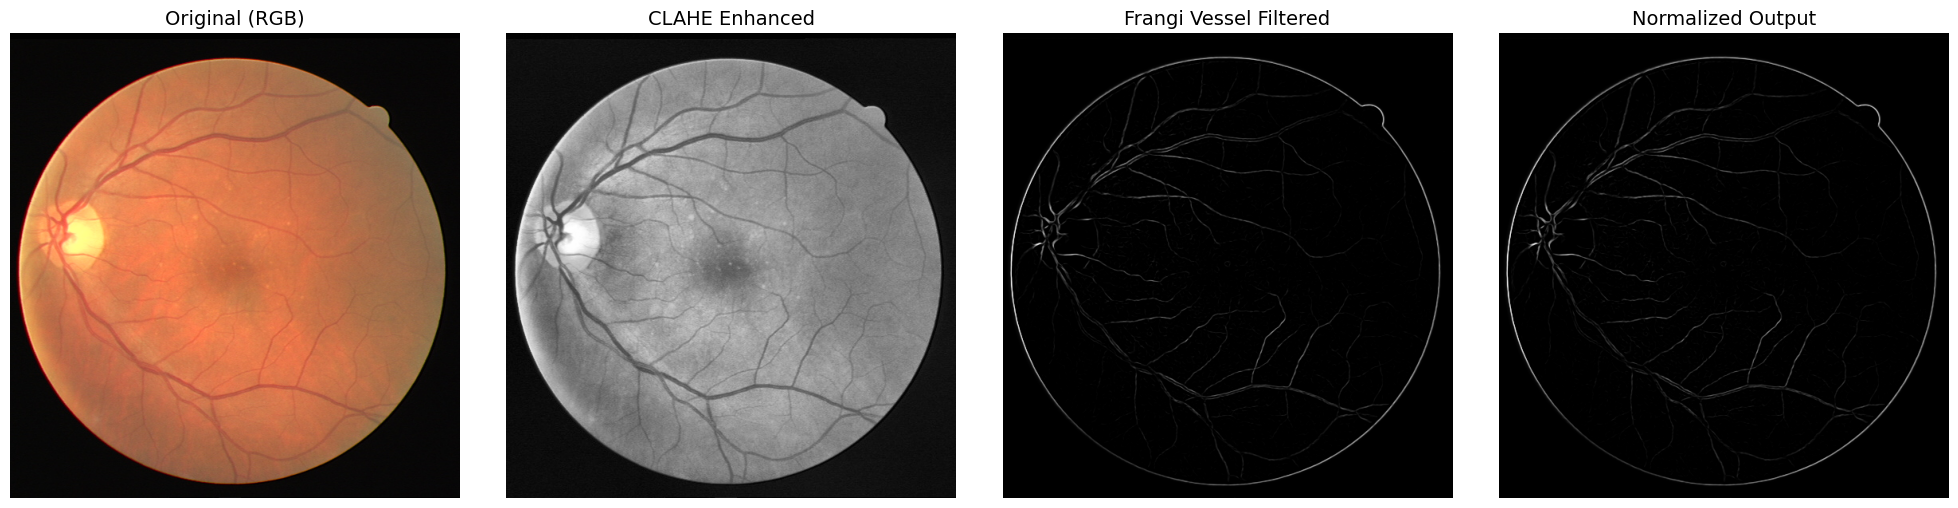

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import exposure
from skimage.filters import frangi

# ------------------- Configuration -------------------
# Path to original image (must be a .tif fundus image)
image_path = '/Users/imamahasan/MyData/Code/Retinal_Vessel_S/training/images/21_training.tif'

# ------------------- Load Original Image -------------------
original_color = np.array(Image.open(image_path))  # RGB
gray = np.array(Image.open(image_path).convert('L'), dtype=np.float32)

# ------------------- Step 1: Original RGB -------------------
img1 = original_color.copy()

# ------------------- Step 2: CLAHE -------------------
gray_norm = (gray - gray.min()) / (gray.max() - gray.min())  # Normalize to [0,1]
img2 = exposure.equalize_adapthist(gray_norm)

# ------------------- Step 3: Frangi Vesselness -------------------
img3 = frangi(img2)

# ------------------- Step 4: Final Normalization -------------------
img4 = (img3 - img3.min()) / (img3.max() - img3.min() + 1e-8)

# ------------------- Optional: Stretch for Display -------------------
img3_display = exposure.rescale_intensity(img3, in_range='image', out_range=(0, 1))
img4_display = exposure.rescale_intensity(img4, in_range='image', out_range=(0, 1))

# ------------------- Plotting -------------------
titles = ['Original (RGB)', 'CLAHE Enhanced', 'Frangi Vessel Filtered', 'Normalized Output']
images = [img1, img2, img3_display, img4_display]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray' if i > 0 else None)
    ax.set_title(titles[i], fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.savefig('preprocessing_pipeline_for_paper.png', dpi=300, bbox_inches='tight')
plt.show()



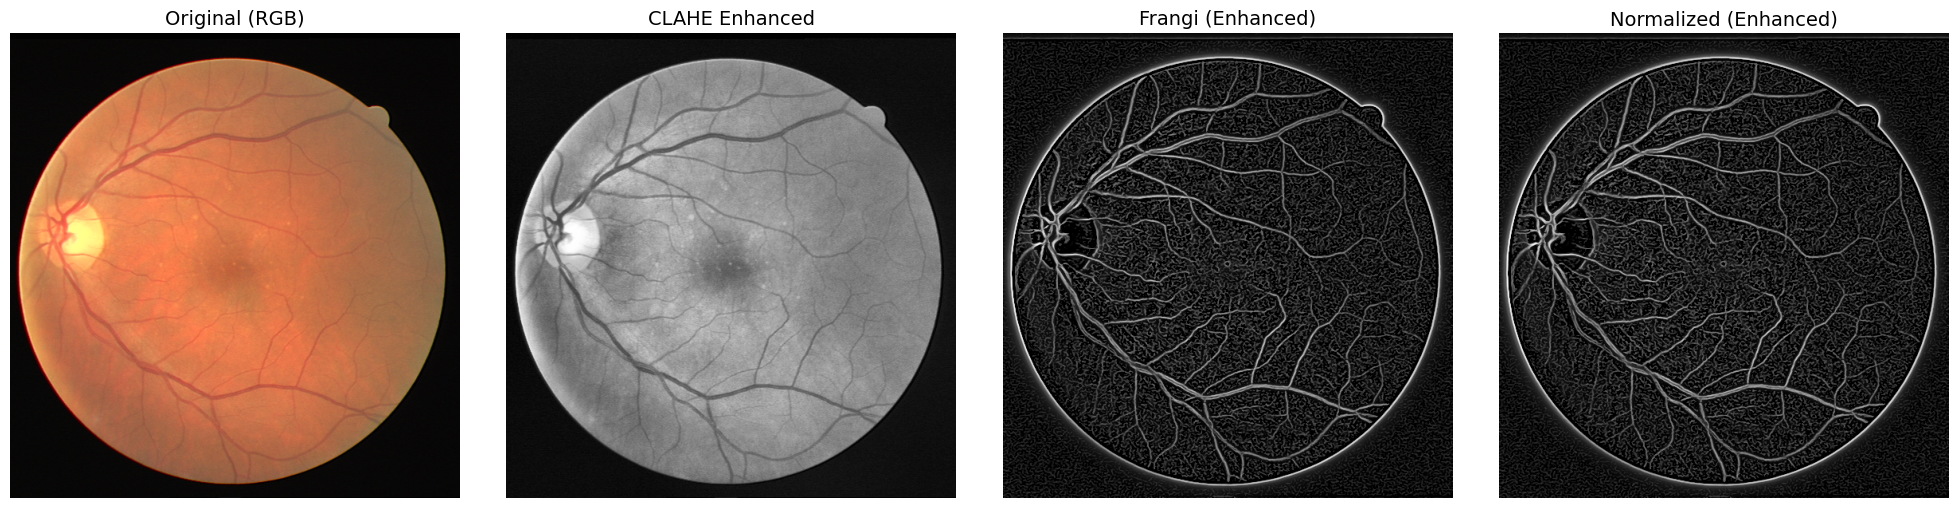

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import exposure
from skimage.filters import frangi

# Load original image
image_path = '/Users/imamahasan/MyData/Code/Retinal_Vessel_S/training/images/21_training.tif'
original_color = np.array(Image.open(image_path))  # RGB
gray = np.array(Image.open(image_path).convert('L'), dtype=np.float32)

# Normalize grayscale to [0,1]
gray_norm = (gray - gray.min()) / (gray.max() - gray.min())

# Step 1: RGB
img1 = original_color

# Step 2: CLAHE
img2 = exposure.equalize_adapthist(gray_norm)

# Step 3: Frangi
img3 = frangi(img2)

# Step 4: Normalized Frangi output
img4 = (img3 - img3.min()) / (img3.max() - img3.min() + 1e-8)

# ✅ Gamma correction for better visualization
def gamma_correct(image, gamma=0.3):
    return np.power(image, gamma)

img3_vis = gamma_correct(img3)
img4_vis = gamma_correct(img4)

# Plotting
titles = ['Original (RGB)', 'CLAHE Enhanced', 'Frangi (Enhanced)', 'Normalized (Enhanced)']
images = [img1, img2, img3_vis, img4_vis]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray' if i > 0 else None)
    ax.set_title(titles[i], fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.savefig('preprocessing_pipeline_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()
